# Dolly Databricks Dataset

We consider the dataset from https://huggingface.co/datasets/databricks/databricks-dolly-15k. 

We work with the json downloaded vevrsion from: https://huggingface.co/datasets/databricks/databricks-dolly-15k/blob/main/databricks-dolly-15k.jsonl


In [1]:
import json
import numpy as np
import pandas as pd
import torch
import importlib
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

import os 
import sys

sys.path.append(os.path.join(os.getcwd(), "../../"))

import src.visualization.plot_rawdata as plotutils

In contrast to other datasets, which saved all data samples inside a `list`, the Dolly dataset saves a `dict`element per line. 
This clashes with json loading format, so we need to read line-by-line.

In [2]:
DATA_PATH = "../raw_instruct/databricks-dolly-15k.json"
# Open the JSON file
with open(DATA_PATH, 'r') as file:
    data = [json.loads(line) for line in file]

In [3]:
print(f"Type of data: {type(data)}\nNumber of entries: {len(data)}")

Type of data: <class 'list'>
Number of entries: 15011


In [4]:
set([sample['category'] for sample in data])

{'brainstorming',
 'classification',
 'closed_qa',
 'creative_writing',
 'general_qa',
 'information_extraction',
 'open_qa',
 'summarization'}

In [5]:
idx = 29

In [6]:
type(data[idx])

dict

In [7]:
data[idx].keys()

dict_keys(['instruction', 'context', 'response', 'category'])

In [8]:
set([elem['category'] for elem in data])

{'brainstorming',
 'classification',
 'closed_qa',
 'creative_writing',
 'general_qa',
 'information_extraction',
 'open_qa',
 'summarization'}

In [9]:
data[idx]

{'instruction': 'Who became king of Holland in 1806?',
 'context': '',
 'response': 'William I of the Netherlands became king of Holland in 1806.',
 'category': 'open_qa'}

In [10]:
for i, elem in enumerate(data):
    if elem['context']:
        idx = i
        print(f"First elem that contains a 'context' is index {idx}")
        break

First elem that contains a 'context' is index 0


#### Check if all elements in data are of type dict and if just one input prompt per data sample (no conversation)

In [11]:
for elem in data:
    if not isinstance(elem, dict):
        print(f"Elem is not a dict! {elem}")
    elif sorted(list(elem.keys())) != sorted(['context', 'instruction', 'response', 'category']):
        print(f"Elem has different keys in dict! {elem}")

In [12]:
del elem

### No data

In [13]:
no_conver_data = []

for elem in data: 
    if not elem['instruction']:
        no_conver_data.append(elem)

In [14]:
len(no_conver_data)

0

So all of the elements in this dataset have an instruction!

In [15]:
del no_conver_data

### Input handling
Each sample in the dataset is of type `dict`.
The keys of that `dict` are `['instruction', 'input', 'output']`. However, the tokenizers do not recognize the `'input'` keyword, so we need to append it to the user's `content`.  

In [16]:
access_tk = os.getenv("HF_API_TOKEN")
device_str = "cuda:0"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
padding_side='left'

tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_tk, device_map=device_str, torch_dtype=torch.float16, padding_side=padding_side)



In [17]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)   

In [18]:
from src.data.rawdata_processor import dolly_generate_rawprompt_text, build_rawprompt_text_batch, build_rawprompt_text_chat

In [19]:
mystring = dolly_generate_rawprompt_text(data[idx], tokenizer)
print(mystring)

When did Virgin Australia start operating?
Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.


In [20]:
build_rawprompt_text_chat(mystring)

[{'role': 'user',
  'content': "When did Virgin Australia start operating?\nContext: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."}]

In [21]:
get_tokens(build_rawprompt_text_chat(mystring), tokenizer)

tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,    605,   3297,    220,   2366,     20,    271, 128009, 128006,
            882, 128007,    271,   4599,   1550,  11463,   8494,   1212,  10565,
           5380,   2014,     25,  11463,   8494,     11,    279,  11380,    836,
            315,  11463,   8494,  35230,  80092,  12604,     11,    374,    459,
          13673,   6108,  33575,     13,   1102,    374,    279,   7928,  33575,
            555,  26155,   1404,    311,   1005,    279,  11463,   6883,     13,
           1102,  65362,   3600,    389,    220,   2148,   6287,    220,   1049,
             15,    439,  11463,   8868,     11,    449,   1403,  14467,    389,
            264,   3254,   6149,     13,   1102,  15187,   1766,   5196,    439,
            264,   3682,  33575,    304,   8494,    596,  13018,   3157,   1306,
            279,  18678,    

In [22]:
print(tokenizer.decode(get_tokens(build_rawprompt_text_batch(mystring, 5), tokenizer)[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 May 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

When did Virgin Australia start operating?
Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




### Analyze lenght of prompts in terms of number of tokens

In [23]:
tmp_model_input = [build_rawprompt_text_chat(dolly_generate_rawprompt_text(elem, tokenizer, truncate=False)) for elem in data]

In [24]:
len(tmp_model_input)

15011

In [25]:
conv_len_tokens = [get_tokens(elem, tokenizer).shape[1] for elem in tmp_model_input]

In [26]:
len(conv_len_tokens)

15011

In [27]:
np.max(conv_len_tokens)

np.int64(5544)

In [28]:
importlib.reload(plotutils)

<module 'src.visualization.plot_rawdata' from '/home/daniel/Documents/llm-testbed/data/notebooks/../../src/visualization/plot_rawdata.py'>

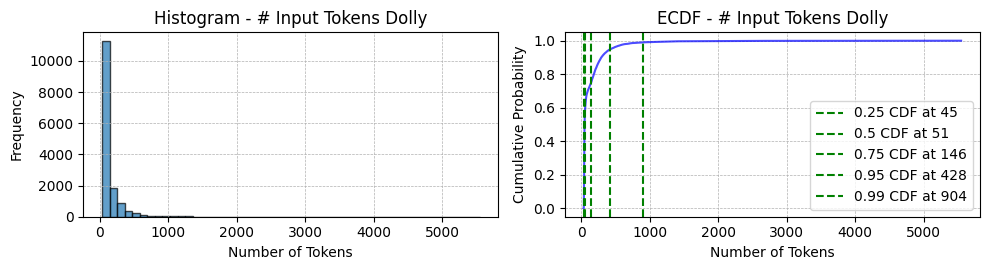

In [29]:
fig = plotutils.plot_histogram_and_cdf(conv_len_tokens, in_size=(10, 2.8), 
                             in_title="# Input Tokens Dolly", x_forcdf=0, cdf_forx=[0.25, 0.5, 0.75, 0.95, 0.99],)

## Convert dataset to pandas
Later, when splitting the datasets, we will have to stratify the splits based on the `category` variable from each data sample. 
Converting the list of dicts to a pandas dataframe will facilitate the stratification of the splits. 

Moreover, after estimating the input tokens lengths, it will help us see the distribution of input token lengths according to `category`. 

In [30]:
df_data = pd.DataFrame(data)

In [31]:
df_data.head()

,instruction,context,response,category
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa
1,Which is a species of fish? Tope or Rope,,Tope,classification
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa


#### Estimate the numer of input tokens

In [32]:
def get_tokens_row(row, tokenizer): 
    return get_tokens(build_rawprompt_text_chat(dolly_generate_rawprompt_text(row, tokenizer, truncate=False)), tokenizer).shape[1]
    

In [33]:
df_data['n_tokens_input'] = df_data.apply(lambda row: get_tokens_row(row, tokenizer), axis=1)

In [34]:
df_data['n_tokens_input'].isna().any()

np.False_

In [35]:
df_data['n_tokens_input'].isna().sum()

np.int64(0)

In [36]:
df_data.head()

,instruction,context,response,category,n_tokens_input
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,148
1,Which is a species of fish? Tope or Rope,,Tope,classification,46
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa,45
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa,57
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,356


In [37]:
importlib.reload(plotutils)

<module 'src.visualization.plot_rawdata' from '/home/daniel/Documents/llm-testbed/data/notebooks/../../src/visualization/plot_rawdata.py'>

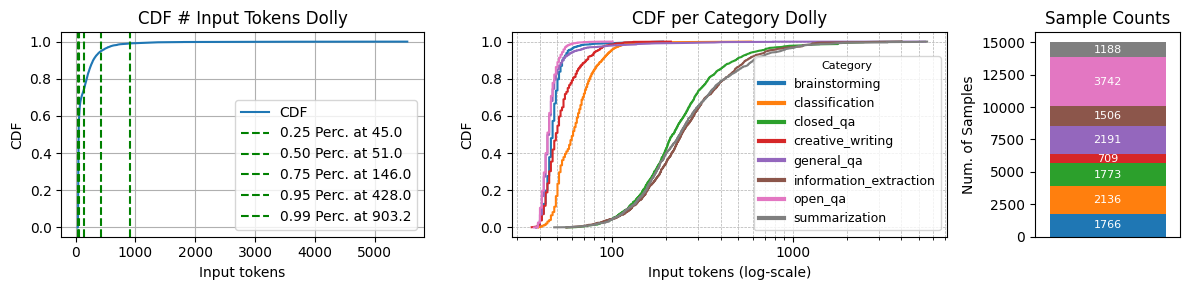

In [38]:
fig = plotutils.plot_dollydataframe_ecdf_threeplot(df_data, figsize=(12,3), title_suffix="Dolly")

In [39]:
fig.savefig("../../outputs/images/raw_data_Dolly_COMPLETE_ntokens_ecdf.pdf", bbox_inches="tight")

In [40]:
np.max(df_data['n_tokens_input'])

np.int64(5544)

In [41]:
np.percentile(df_data["n_tokens_input"], [25, 50, 75, 99])

array([ 45. ,  51. , 146. , 903.2])

# Split the datasets

We do stratified splits according to the `'category'` variable of the data samples 

In [42]:
print(f"Length of records: {len(df_data)}")
df_data.head()

Length of records: 15011


,instruction,context,response,category,n_tokens_input
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,148
1,Which is a species of fish? Tope or Rope,,Tope,classification,46
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa,45
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa,57
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,356


#### First, sample a subset of the data

In [43]:
SEED = 42
MAXIMUM = 2000

In [44]:
# Stratified sampling of 2000 samples from the full dataset
df_sampled, _ = train_test_split(df_data, train_size=2000, stratify=df_data['category'], random_state=SEED)

In [45]:
print(f"Length of records: {len(df_sampled)}")

Length of records: 2000


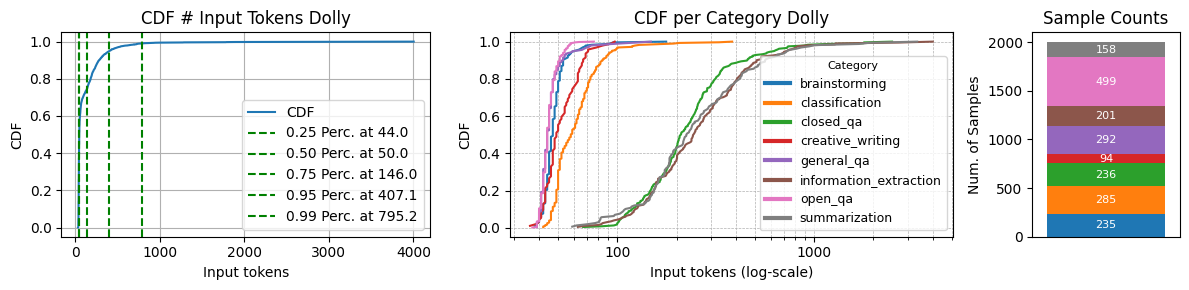

In [46]:
fig = plotutils.plot_dollydataframe_ecdf_threeplot(df_sampled, figsize=(12,3), title_suffix="Dolly")

In [47]:
np.percentile(df_sampled["n_tokens_input"], [25, 50, 75, 99])

array([ 44.  ,  50.  , 146.  , 795.17])

In [48]:
np.mean(df_sampled["n_tokens_input"])

np.float64(125.874)

In [49]:
np.std(df_sampled["n_tokens_input"])

np.float64(209.64290382457497)

In [52]:
df_sampled["n_tokens_input"].min()

np.int64(36)

In [51]:
fig.savefig("../../outputs/images/raw_data_Dolly_ntokens_ecdf.pdf", bbox_inches="tight")

#### Now, do the train-validation-test splits

In [45]:
if 'n_tokens_input' in df_sampled.columns: 
    df_sampled = df_sampled.drop(columns=['n_tokens_input'])

In [46]:
df_sampled.head()

,instruction,context,response,category
9534,How do I become successful?,,Success is not a measure of wealth or assets a...,general_qa
13543,"I have 13 identical balls that weigh the same,...",,We can start with basic iteration to weigh all...,brainstorming
14792,In which years did the Women's New Zealand cri...,,2000,brainstorming
8125,What are some criticism of Betty Friedan's Fem...,,"While groundbreaking, Betty Friedman took a na...",open_qa
10558,Extract the name of the country where Djidonou...,"Born in Domont, France, Djidonou has played cl...",France,information_extraction


In [47]:
df_train, df_tmp = train_test_split(df_sampled, test_size=0.3, stratify=df_sampled['category'], random_state=SEED)

In [48]:
df_validate, df_test = train_test_split(df_tmp, test_size=1/3, stratify=df_tmp['category'], random_state=SEED)

In [49]:
print(f"Percentage of training data: {round(len(df_train)/len(df_sampled), 4)}")
print(f"Percentage of validation data: {round(len(df_validate)/len(df_sampled), 4)}")
print(f"Percentage of test data: {round(len(df_test)/len(df_sampled), 4)}")

Percentage of training data: 0.7
Percentage of validation data: 0.2
Percentage of test data: 0.1


#### Convert to list of dicts again

In [50]:
data_train = df_train.to_dict(orient='records')
data_val = df_validate.to_dict(orient='records')
data_test = df_test.to_dict(orient='records')

In [51]:
# Check if the lengths agree
print(f"Percentage of training data: {round(len(data_train)/len(data), 4)}")
print(f"Percentage of validation data: {round(len(data_val)/len(data), 4)}")
print(f"Percentage of test data: {round(len(data_test)/len(data), 4)}")

Percentage of training data: 0.0933
Percentage of validation data: 0.0266
Percentage of test data: 0.0133


In [52]:
def save_data(dataset, path):
    with open(path, 'w') as f:
        json.dump(dataset, f)
    print(f"Dataset saved to path {path}")

In [53]:
save_path_src = "../raw_instruct/DollyDataset/raw_DollyDataset"

In [54]:
save_data(data_train, save_path_src + "_train.json")

Dataset saved to path ../raw_instruct/DollyDataset/raw_DollyDataset_train.json


In [55]:
save_data(data_val, save_path_src + "_validate.json")

Dataset saved to path ../raw_instruct/DollyDataset/raw_DollyDataset_validate.json


In [56]:
save_data(data_test, save_path_src + "_test.json")

Dataset saved to path ../raw_instruct/DollyDataset/raw_DollyDataset_test.json


# PREVIOUS CODE

In [14]:
sentence=[{'role': 'user', 
           'content': "When did Virgin Australia start operating?\nContext: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."}]

In [15]:
def get_tokens(sentence, tokenizer):
    return tokenizer.apply_chat_template(sentence, return_tensors="pt", add_generation_prompt=True)   

In [16]:
print(tokenizer.batch_decode(get_tokens(sentence, tokenizer))[0])

<bos><start_of_turn>user
When did Virgin Australia start operating?
Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.<end_of_turn>
<start_of_turn>model



In [17]:
# Find the first data sample with a 'input' element.
for i,elem in enumerate(data): 
    if elem['context']:
        tmp = elem['instruction']+"\nContext: "+elem['context']
        print(f"Index: {i}\nPrompt:\n'{tmp}'")
        break

Index: 0
Prompt:
'When did Virgin Australia start operating?
Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.'


In [18]:
del elem
del tmp

In [19]:
get_tokens(sentence, tokenizer).shape

torch.Size([1, 131])

In [20]:
del sentence

In [21]:
idx = 0

In [22]:
print(tokenizer.batch_decode(get_tokens([{'role': 'user',
                                          'content': data[idx]['instruction']+"\nContext: "+data[idx]['context']}], 
                                        tokenizer))[0])

<bos><start_of_turn>user
When did Virgin Australia start operating?
Context: Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.<end_of_turn>
<start_of_turn>model



In [23]:
get_tokens([{'role': 'user',
             'content': data[idx]['instruction']+"\nContext: "+data[idx]['context']}], 
           tokenizer).shape

torch.Size([1, 131])

In [24]:
del idx